In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Load and prepare data

In [2]:
df = pd.read_csv('data/stock_data.csv').sort_values('date', ignore_index=False)

In [3]:
# create lag 1 for each column
for col in df.columns:
    df[f'{col}_lag1'] = df[col].shift(1)


In [4]:
df['date'] = pd.to_datetime(df['date'], utc=True)
# extract date to string
df['dt'] = df['date'].dt.strftime('%Y-%m-%d')
df.head()


,date,spy_open,spy_high,spy_low,spy_close,spy_volume,qqq_open,qqq_high,qqq_low,qqq_close,...,spy_high_lag1,spy_low_lag1,spy_close_lag1,spy_volume_lag1,qqq_open_lag1,qqq_high_lag1,qqq_low_lag1,qqq_close_lag1,qqq_volume_lag1,dt
0,2024-02-12 05:00:00+00:00,499.617667,501.940437,498.690525,499.428253,56502300,436.362999,438.560106,434.076015,434.765106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-12
1,2024-02-13 05:00:00+00:00,492.998240,495.550308,489.200043,492.549622,113099200,426.715758,430.700479,424.768321,427.984070,...,501.940437,498.690525,499.428253,56502300.0,436.362999,438.560106,434.076015,434.765106,33203300.0,2024-02-13
2,2024-02-14 05:00:00+00:00,495.251241,497.524178,492.868629,497.025726,68387800,430.690515,433.077344,428.313653,432.647919,...,495.550308,489.200043,492.549622,113099200.0,426.715758,430.700479,424.768321,427.984070,64491700.0,2024-02-14
3,2024-02-15 05:00:00+00:00,497.743502,500.644492,497.254999,500.455078,61683000,433.347001,434.405599,430.760394,433.936218,...,497.524178,492.868629,497.025726,68387800.0,430.690515,433.077344,428.313653,432.647919,45092700.0,2024-02-15
4,2024-02-16 05:00:00+00:00,500.146049,501.312408,497.205174,497.962830,75461200,434.315737,434.415581,429.282384,430.001434,...,500.644492,497.254999,500.455078,61683000.0,433.347001,434.405599,430.760394,433.936218,38796100.0,2024-02-16


In [5]:
# data before apr 2024 as train, after as test 
df_train = df[df['date'] < pd.to_datetime('2024-04-01', utc=True)].dropna()
df_test = df[df['date'] >= pd.to_datetime('2024-04-01', utc=True)].reset_index(drop=True)


## Train simple model

In [6]:
x_col = ['spy_close_lag1', 'qqq_close_lag1']
y_col = ['qqq_close']

model_ols = LinearRegression(fit_intercept=True)
model_ols.fit(df_train[x_col], df_train[y_col])


LinearRegression()

In [10]:
model_ols.coef_

array([[0.49640769, 0.04438127]])

In [7]:
def recursive_predictions(model, initial_data, steps, df_test, x_col, ar_col):
    predictions = []
    current_data = initial_data.copy()
    
    for i in range(steps):
        # Predict the next value
        next_value = model.predict(current_data[x_col])
        predictions.append(next_value.item())
        
        current_data = df_test.loc[[i], x_col].reset_index(drop=True)
        current_data.loc[0, ar_col] = next_value.item()
        
    return predictions

# Generate recursive predictions for the next 10 steps
initial_data = df_train.tail(1)
predicted_values = recursive_predictions(model_ols, initial_data, df_test.shape[0], df_test, x_col, 'qqq_close_lag1')


In [8]:
df_test['qqq_close_pred'] = predicted_values


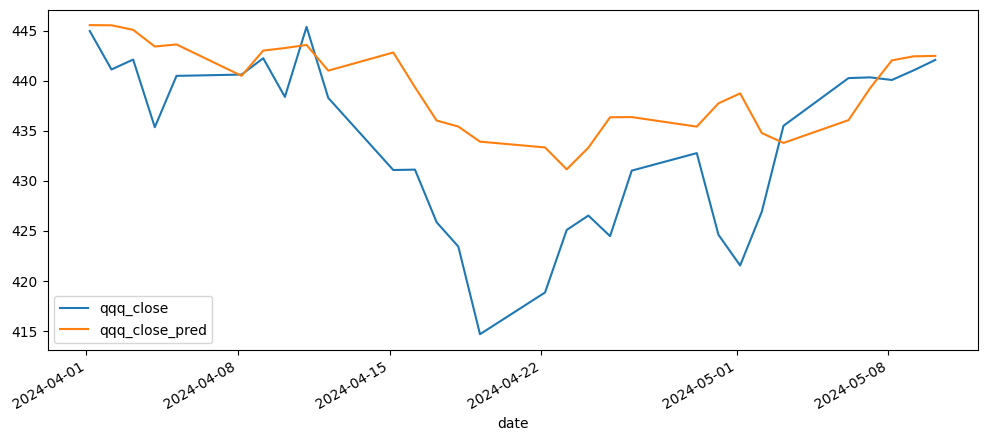

In [9]:
df_test.plot(x='date', y=['qqq_close', 'qqq_close_pred'], figsize=(12, 5))
plt.show()